In [33]:
#Import libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#!pip install missingno
import missingno as msno

In [34]:
df = pd.read_csv(r'C:\Users\dhami\Downloads\GitHub_Capstone_Project\CTREA-Dynamics\data\Real_Estate_Sales_2001-2020_GL.csv')
df.head()

C:\Users\dhami\AppData\Local\Temp\ipykernel_25928\1508374523.py:1: DtypeWarning: Columns (8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'C:\Users\dhami\Downloads\GitHub_Capstone_Project\CTREA-Dynamics\data\Real_Estate_Sales_2001-2020_GL.csv')


,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Non Use Code,Assessor Remarks,OPM remarks,Location
0,2020348,2020,09/13/2021,Ansonia,230 WAKELEE AVE,150500.0,325000.0,0.4630,Commercial,NaN,NaN,NaN,NaN,NaN
1,20002,2020,10/02/2020,Ashford,390 TURNPIKE RD,253000.0,430000.0,0.5883,Residential,Single Family,NaN,NaN,NaN,NaN
2,200212,2020,03/09/2021,Avon,5 CHESTNUT DRIVE,130400.0,179900.0,0.7248,Residential,Condo,NaN,NaN,NaN,NaN
3,200243,2020,04/13/2021,Avon,111 NORTHINGTON DRIVE,619290.0,890000.0,0.6958,Residential,Single Family,NaN,NaN,NaN,NaN
4,200377,2020,07/02/2021,Avon,70 FAR HILLS DRIVE,862330.0,1447500.0,0.5957,Residential,Single Family,NaN,NaN,NaN,NaN


In [35]:
df.shape

(997213, 14)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 997213 entries, 0 to 997212
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Serial Number     997213 non-null  int64  
 1   List Year         997213 non-null  int64  
 2   Date Recorded     997211 non-null  object 
 3   Town              997213 non-null  object 
 4   Address           997162 non-null  object 
 5   Assessed Value    997213 non-null  float64
 6   Sale Amount       997213 non-null  float64
 7   Sales Ratio       997213 non-null  float64
 8   Property Type     614767 non-null  object 
 9   Residential Type  608904 non-null  object 
 10  Non Use Code      289681 non-null  object 
 11  Assessor Remarks  149864 non-null  object 
 12  OPM remarks       9934 non-null    object 
 13  Location          197697 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 106.5+ MB


## Features Observation
1. Serial Number : Unique values, for identification on entry, not useful.
2. List Year : Ranges from 2001-2020
3. Date Recorded : sales data or recorded entry date in datetime format
                   some have year while majority has dd-mm-yyyy format
4. Town : Connectnicut state town names, no blank values 
5. Address : street no with combination of landmark is visible, locality area name can be extracted for clustering
6. Assessed Value : All numeric and minimum values ranges as 0 meaning property for asses in its lifetime
7. Sale Amount : All numeric and min value is 0 stating forclosure of property, we can study customer segmentation based on area where forclosure are happening and dependent features related for taking place.
8. Sales Ratio : max above 1 also values are as high as 300, interest paymnent is remark, need to understand this outliers are creation of anomaly or improper data!
9. Property Type :  Blanks are found
10. Residential Type :  Blanks are found, vacant/commenrical property type are major contributor
11. Non Use Code : numeric and alphabets also repettive is observed so is data duplicated or code has different meaning will need to find.
12. Assessor Remarks : Mixed type comments on each entryies observed with some blanks
13. OPM remarks : Very Generic relies and also what is OPM must be understood
14. Location : Blanks are majority around 799517 nos, no worries based on address can be pin-pointed in mapping

        Data Cleaning shall be initaated feature by feature

In [37]:
df.drop('Serial Number', axis=1, inplace=True)

In [38]:
#missing value code
missing_values = df.isnull().sum().sort_values(ascending=False) 
missing_values = missing_values[missing_values > 0]
print('Missing Values Count are as follows:\n',missing_values)


Missing Values Count are as follows:
 OPM remarks         987279
Assessor Remarks    847349
Location            799516
Non Use Code        707532
Residential Type    388309
Property Type       382446
Address                 51
Date Recorded            2
dtype: int64


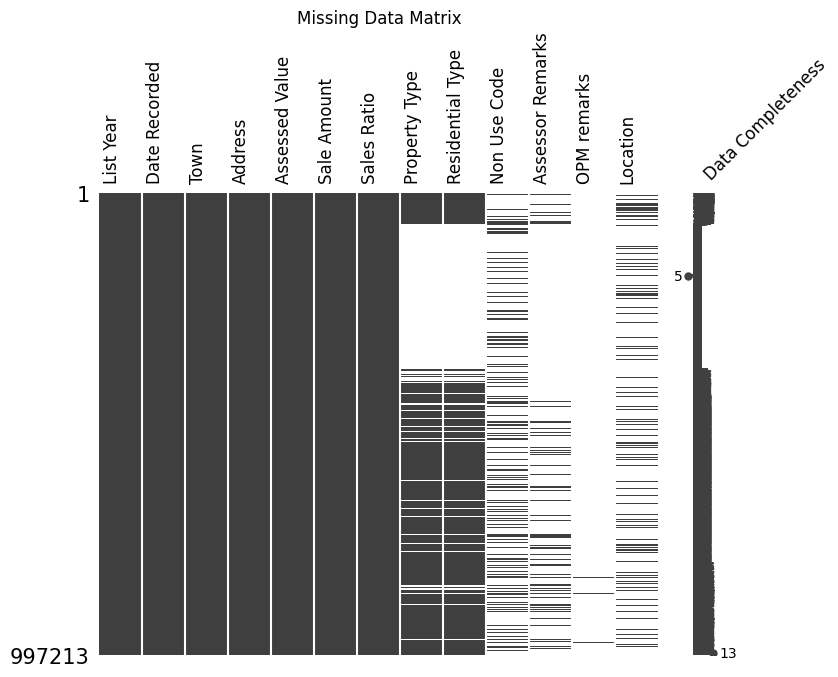

In [39]:
#missing value visualization
msno.matrix(df, figsize=(8, 6), sparkline=True, fontsize=12, labels=True)
plt.title('Missing Data Matrix', fontsize=12, rotation = 0)
# Rotate x-axis labels
plt.xticks(rotation=90, ha='right') 
plt.show()

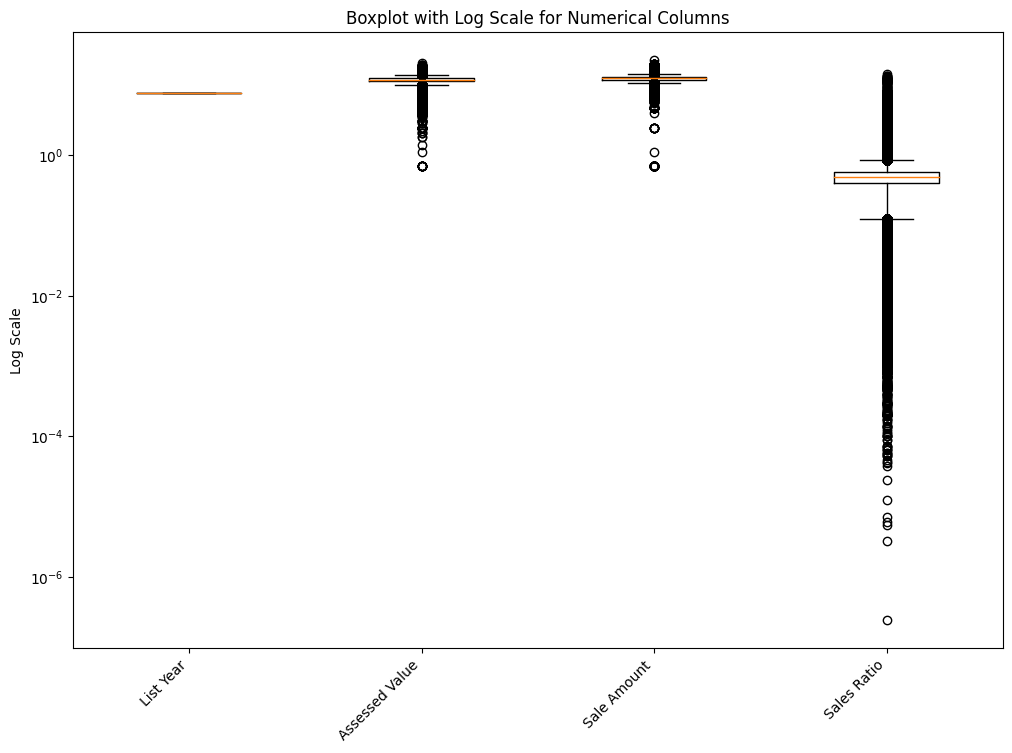

In [40]:
# Select numerical columns (excluding 'object' type)
numerical_columns = df.select_dtypes(exclude='object').columns

# Boxplot with log scale
fig, ax = plt.subplots(figsize=(12, 8))

# Using np.log1p to handle potential zero values (log(0+1) = 0)
ax.boxplot(np.log1p(df[numerical_columns]), labels=numerical_columns)

# Set y-axis to log scale
ax.set_yscale('log')

# Set labels and title
plt.xticks(rotation=45, ha='right')
plt.title('Boxplot with Log Scale for Numerical Columns')
plt.ylabel('Log Scale')

plt.show()

In [41]:
def detect_outliers(data):
    numeric_data = data.select_dtypes(exclude='object')
    columns = list(numeric_data.columns)
    outliers_info = []

    for column in columns:
        # IQR method
        q1 = numeric_data[column].quantile(0.25)
        q3 = numeric_data[column].quantile(0.75)
        iqr = q3 - q1
        lower_limit = q1 - 1.5 * iqr
        upper_limit = q3 + 1.5 * iqr

        # Detect outliers
        outliers = (numeric_data[column] < lower_limit) | (numeric_data[column] > upper_limit)

        # Count the number of outliers
        num_outliers = outliers.sum()
        percentage_outliers = round((outliers.sum()/numeric_data.shape[0]) * 100,2)

        # Append information to the list
        outliers_info.append({
            'Column': column,
            'Lower Limit': lower_limit,
            'Upper Limit': upper_limit,
            'Num Outliers': num_outliers,
            'Outlier Indices': numeric_data[outliers].index.tolist(),
            'Outliers_percentage' : percentage_outliers
        })

    # Convert the list of dictionaries to a DataFrame
    outliers_df = pd.DataFrame(outliers_info)

    return outliers_df

# Example usage
outliers_df = detect_outliers(df)


In [42]:
outliers_df

,Column,Lower Limit,Upper Limit,Num Outliers,Outlier Indices,Outliers_percentage
0,List Year,1986.000000,2034.00000,0,[],0.00
1,Assessed Value,-119340.000000,432500.00000,90623,"[3, 4, 5, 8, 12, 13, 35, 40, 55, 74, 82, 84, 8...",9.09
2,Sale Amount,-197500.000000,702500.00000,82900,"[3, 4, 5, 8, 33, 35, 40, 44, 55, 74, 82, 84, 8...",8.31
3,Sales Ratio,0.038836,1.23314,100129,"[6, 32, 50, 60, 75, 86, 94, 96, 127, 133, 139,...",10.04


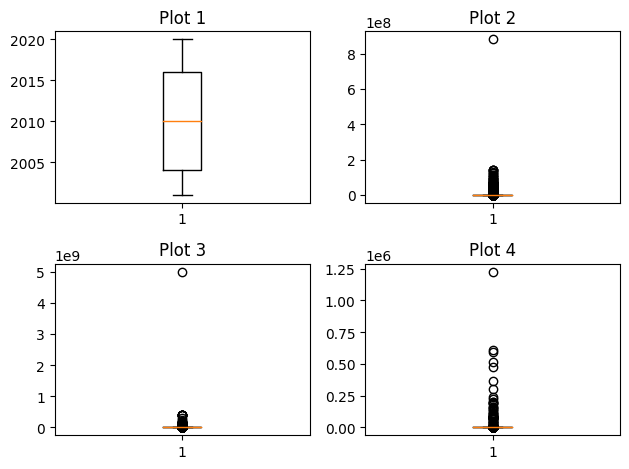

In [43]:
#simple code

# Create a figure and an array of subplots
fig, ax = plt.subplots(nrows=2, ncols=2)  # You can adjust the number of rows and columns as needed

# Plot on the first subplot (index 0,0)
ax[0, 0].boxplot(df['List Year'])
ax[0, 0].set_title('Plot 1')

# Plot on the second subplot (index 0,1)
ax[0, 1].boxplot(df['Assessed Value'])
ax[0, 1].set_title('Plot 2')

# Plot on the third subplot (index 1,0)
ax[1, 0].boxplot(df['Sale Amount'])
ax[1, 0].set_title('Plot 3')

# Plot on the fourth subplot (index 1,1)
ax[1, 1].boxplot(df['Sales Ratio'])
ax[1, 1].set_title('Plot 4')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()


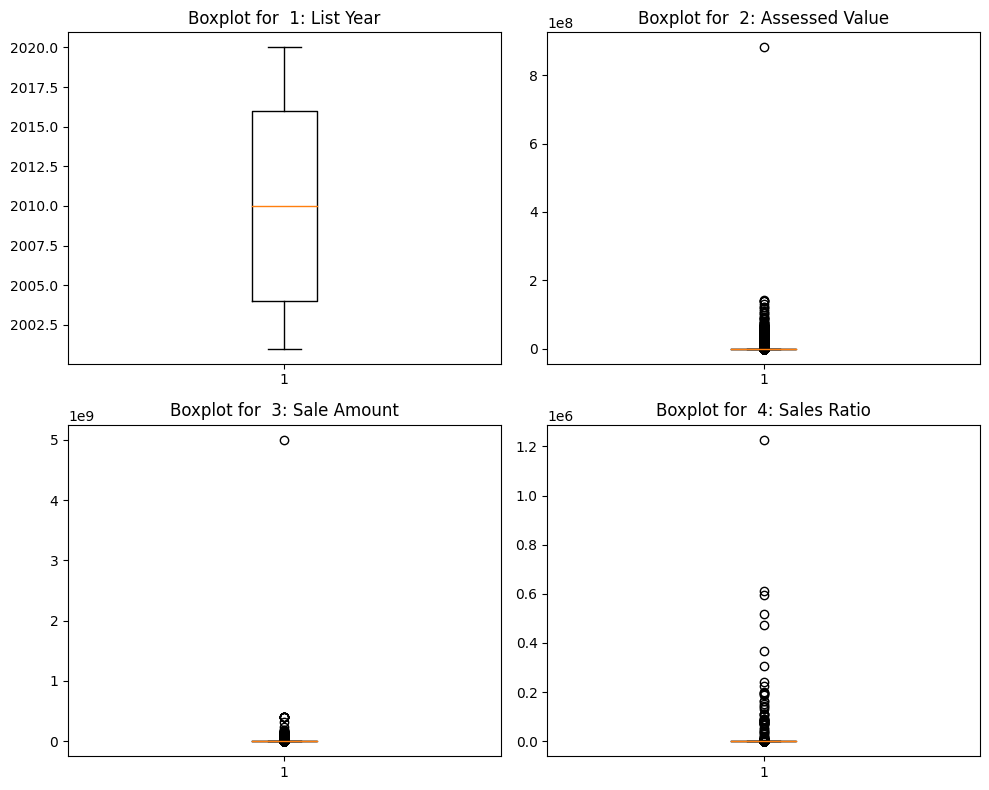

In [44]:
# Get the list of columns to plot
columns_to_plot = ['List Year', 'Assessed Value', 'Sale Amount', 'Sales Ratio']

# Determine the number of rows and columns for subplots
num_rows = 2
num_cols = 2

# Create a figure and an array of subplots
fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 8))  # You can adjust the figure size as needed

# Flatten the ax array for easier iteration
ax_flat = ax.flatten()

# Iterate through columns and plot boxplots
for i, column in enumerate(columns_to_plot):
    row_index = i // num_cols
    col_index = i % num_cols

    ax_flat[i].boxplot(df[column])
    ax_flat[i].set_title(f'Boxplot for  {i + 1}: {column}')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()


In [45]:
round(df.describe(include='all'),2).T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
List Year,997213.0,NaN,NaN,NaN,2010.19,6.24,2001.0,2004.0,2010.0,2016.0,2020.0
Date Recorded,997211,6387,07/01/2005,877,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Town,997213,170,Bridgeport,34201,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Address,997162,714371,MULTI ADDRESSES,620,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Assessed Value,997213.0,NaN,NaN,NaN,279143.67,1670609.86,0.0,87600.0,138390.0,225560.0,881510000.0
Sale Amount,997213.0,NaN,NaN,NaN,391151.18,5347270.21,0.0,140000.0,225000.0,365000.0,5000000000.0
Sales Ratio,997213.0,NaN,NaN,NaN,10.45,1890.19,0.0,0.49,0.62,0.79,1226420.0
Property Type,614767,11,Single Family,401612,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Residential Type,608904,5,Single Family,445016,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Non Use Code,289681,106,25 - Other,59916,NaN,NaN,NaN,NaN,NaN,NaN,NaN


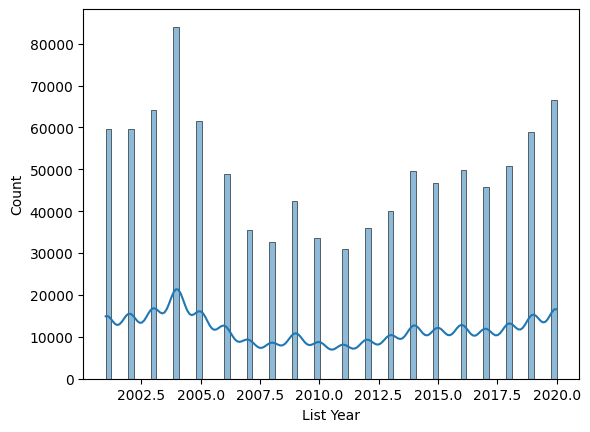

In [46]:
sns.histplot(df['List Year'], kde=True)
plt.show()

In [61]:
round(df['List Year'].value_counts(normalize=True).sort_values(ascending=False)*100,2)

List Year
2004    8.43
2020    6.68
2003    6.44
2005    6.18
2002    5.98
2001    5.98
2019    5.91
2018    5.09
2016    4.99
2014    4.97
2006    4.89
2015    4.68
2017    4.58
2009    4.26
2013    4.01
2012    3.61
2007    3.57
2010    3.36
2008    3.28
2011    3.12
Name: proportion, dtype: float64

In [48]:
round(df['Date Recorded'].value_counts(normalize=True).sort_values(ascending=False)*100,2).head(20)

Date Recorded
07/01/2005    0.09
08/01/2005    0.09
07/01/2004    0.08
06/30/2005    0.08
09/30/2005    0.08
07/01/2002    0.08
11/01/2004    0.08
10/01/2004    0.08
05/02/2005    0.07
08/02/2004    0.07
04/01/2005    0.07
07/29/2005    0.07
09/01/2005    0.07
06/01/2005    0.07
07/01/2003    0.06
05/03/2004    0.06
10/01/2001    0.06
06/30/2004    0.06
06/28/2002    0.06
12/01/2004    0.06
Name: proportion, dtype: float64

In [49]:
round(df['Town'].value_counts(normalize=True).sort_values(ascending=False)*100,2).head(20)

Town
Bridgeport       3.43
Stamford         3.26
Waterbury        2.86
Norwalk          2.40
New Haven        2.14
Danbury          2.04
West Hartford    1.99
Hartford         1.89
Milford          1.78
Meriden          1.76
Greenwich        1.74
Bristol          1.70
Stratford        1.67
New Britain      1.65
Manchester       1.64
Hamden           1.62
Fairfield        1.59
East Hartford    1.38
Torrington       1.32
Middletown       1.24
Name: proportion, dtype: float64

In [50]:
round(df['Address'].value_counts(normalize=True).sort_values(ascending=False)*100,2).head(20)

Address
MULTI ADDRESSES          0.06
8 SOUTH RD               0.04
51 OLD SPRINGFIELD RD    0.02
312 N BISHOP AVE         0.01
RIGGS ST                 0.01
71 AIKEN ST              0.01
42 PIERCE RD             0.01
166 OLD BROOKFIELD RD    0.01
25 GRAND ST              0.01
97 RICHARDS AVE          0.01
50 AIKEN ST              0.01
41 WOLFPIT AVE           0.01
RIVER RD                 0.01
4 DASKAMS LN             0.01
POCONO PT RD             0.01
325 LAFAYETTE ST         0.01
ELM ST                   0.01
100 RICHARDS AVE         0.01
MAIN ST                  0.01
33 NORTH WATER ST        0.01
Name: proportion, dtype: float64

In [51]:
round(df['Assessed Value'].value_counts(normalize=True).sort_values(ascending=False)*100,2).head(20)

Assessed Value
0.0         0.70
17500.0     0.06
105000.0    0.06
35000.0     0.05
70000.0     0.05
63000.0     0.05
10500.0     0.04
84000.0     0.04
28000.0     0.04
12600.0     0.04
112000.0    0.04
87500.0     0.04
126000.0    0.04
98000.0     0.04
91000.0     0.04
56000.0     0.04
77000.0     0.04
42000.0     0.04
140000.0    0.03
101500.0    0.03
Name: proportion, dtype: float64

In [52]:
round(df['Sale Amount'].value_counts(normalize=True).sort_values(ascending=False)*100,2).head(20)

Sale Amount
150000.0    0.94
200000.0    0.90
250000.0    0.85
175000.0    0.76
225000.0    0.74
180000.0    0.74
160000.0    0.72
300000.0    0.70
165000.0    0.69
125000.0    0.67
170000.0    0.67
100000.0    0.66
190000.0    0.66
220000.0    0.65
210000.0    0.65
185000.0    0.63
230000.0    0.63
140000.0    0.62
240000.0    0.61
215000.0    0.60
Name: proportion, dtype: float64

In [53]:
round(df['Sales Ratio'].value_counts(normalize=True).sort_values(ascending=False)*100,2).head(20)

Sales Ratio
0.000000    0.85
0.700000    0.10
1.000000    0.06
0.560000    0.04
0.630000    0.03
0.600000    0.03
0.420000    0.03
0.500000    0.03
0.490000    0.03
0.525000    0.02
0.350000    0.02
0.840000    0.02
0.616000    0.02
0.504000    0.02
0.466667    0.02
0.588000    0.02
0.620000    0.02
0.672000    0.02
0.660000    0.02
0.650000    0.02
Name: proportion, dtype: float64

In [54]:
round(df['Property Type'].value_counts(normalize=True).sort_values(ascending=False)*100,2).head(20)

Property Type
Single Family     65.33
Condo             17.15
Residential        9.88
Two Family         4.30
Three Family       2.05
Vacant Land        0.51
Four Family        0.35
Commercial         0.32
Apartments         0.08
Industrial         0.04
Public Utility     0.00
Name: proportion, dtype: float64

In [55]:
round(df['Residential Type'].value_counts(normalize=True).sort_values(ascending=False)*100,2).head(20)

Residential Type
Single Family    73.08
Condo            19.34
Two Family        4.86
Three Family      2.31
Four Family       0.40
Name: proportion, dtype: float64

In [56]:
round(df['Non Use Code'].value_counts(normalize=True).sort_values(ascending=False)*100,2).head(20)

Non Use Code
25 - Other                     20.68
14 - Foreclosure               18.10
07 - Change in Property        11.82
08 - Part Interest              5.35
7.0                             4.96
01 - Family                     4.52
7                               3.25
1.0                             2.09
10 - A Will                     1.77
8.0                             1.76
06 - Portion of Property        1.51
28 - Use Assessment             1.50
1                               1.44
18 - In Lieu Of Foreclosure     1.27
25.0                            1.23
8                               1.20
15 - Government Agency          1.16
6.0                             1.16
03 - Inter Corporation          1.04
25                              1.00
Name: proportion, dtype: float64

In [57]:
round(df['Assessor Remarks'].value_counts(normalize=True).sort_values(ascending=False)*100,2).head(20)

Assessor Remarks
ESTATE SALE                    3.37
BELOW MARKET                   1.71
SHORT SALE                     1.67
NEW CONSTRUCTION               1.37
FORECLOSURE                    1.23
SALE OF FORECLOSED PROPERTY    1.10
MOBILE HOME                    1.02
SALES RATIO                    0.90
BANK SALE                      0.72
qualified sale                 0.70
OUT OF FORECLOSURE             0.60
Foreclosure related sale       0.59
PRIVATE SALE                   0.55
BELOW MARKET VALUE             0.49
ESTATE                         0.48
MULTIPLE PARCEL SALE           0.45
FAMILY SALE                    0.44
estate sale                    0.40
SHORT SALE PER MLS             0.38
PUD                            0.38
Name: proportion, dtype: float64

In [58]:
round(df['OPM remarks'].value_counts(normalize=True).sort_values(ascending=False)*100,2).head(20)

OPM remarks
GOOD SALE PER MLS                    9.84
NO MLS                               5.03
NEW CONSTRUCTION                     3.47
SHORT SALE PER MLS                   3.28
TOTAL RENOVATION PER MLS             3.18
ESTATE SALE                          2.32
TOTAL REMODEL PER MLS                1.98
PURCHASE OF A FORECLOSED PROPERTY    1.45
BELOW MARKET                         1.25
COMPLETELY RENOVATED PER MLS         1.03
NOT A VALID SALE PER TOWN SITE       0.99
BANK OWNED PER MLS                   0.90
FORECLOSURE PER TOWN SITE            0.77
MOBILE HOME                          0.75
BANK SALE PER MLS                    0.67
BANK SALE PER TOWN SITE              0.63
RENOVATED PER MLS                    0.62
SALE OF A FORECLOSED PROPERTY        0.49
RATIO                                0.41
RENOVATIONS PER MLS                  0.38
Name: proportion, dtype: float64

In [59]:
round(df['Location'].value_counts(normalize=True).sort_values(ascending=False)*100,2).head(20)

Location
POINT (-72.36336 41.97461)    0.09
POINT (-73.41854 41.13449)    0.07
POINT (-73.45225 41.096)      0.04
POINT (-73.06359 41.52255)    0.04
POINT (-72.96095 41.54989)    0.04
POINT (-72.48036 41.86001)    0.04
POINT (-73.5489 41.05871)     0.03
POINT (-72.63429 41.74447)    0.03
POINT (-72.95827 41.86658)    0.03
POINT (-72.0655 41.55307)     0.03
POINT (-73.45236 41.09675)    0.03
POINT (-72.89863 41.38489)    0.03
POINT (-72.77113 41.32067)    0.03
POINT (-73.53139 41.06391)    0.03
POINT (-73.56373 41.03532)    0.02
POINT (-73.10017 41.8392)     0.02
POINT (-72.5033 41.82478)     0.02
POINT (-73.56966 41.04706)    0.02
POINT (-72.67743 41.27808)    0.02
POINT (-73.10125 41.255)      0.02
Name: proportion, dtype: float64

In [60]:
df.columns

Index(['List Year', 'Date Recorded', 'Town', 'Address', 'Assessed Value',
       'Sale Amount', 'Sales Ratio', 'Property Type', 'Residential Type',
       'Non Use Code', 'Assessor Remarks', 'OPM remarks', 'Location'],
      dtype='object')